<a href="https://colab.research.google.com/github/JoannaBroniarek/DCGAN-for-MRI-images/blob/master/Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
# !ls '/gdrive/My Drive/NeuralNetworks/datasets/MICCAI_BraTS_2019_Data_Training/HGG'

In [0]:
!pip install -q SimpleITK dltk

     |████████████████████████████████| 42.5MB 100kB/s 
     |████████████████████████████████| 296kB 57.4MB/s 


In [0]:
!pip install -q opencv-python imageio

In [0]:
# !pip install -q tensorflow-gpu==2.0.0

In [0]:
%tensorflow_version 2.x

In [0]:
import SimpleITK as sitk
import os
import tensorflow as tf
import pandas as pd
import cv2
from tqdm import tqdm

from matplotlib import pyplot as plt
from dltk.io.augmentation import *
from dltk.io.preprocessing import *

import glob
import imageio
import PIL
import time

from IPython import display

%matplotlib inline

In [0]:
tf.__version__

'2.2.0-rc1'

In [0]:
tf.config.list_physical_devices('GPU')
# tf.test.is_gpu_available()

[]

In [0]:
def load_img(file_path, subject_id):
  x = []
  
  #  Construct a file path to read an image from.
  t1_img = os.path.join(file_path, '{}/{}_t1.nii.gz'.format(subject_id, subject_id))

  # Read the .nii image containing a brain volume with SimpleITK and get 
  # the numpy array:
  sitk_t1 = sitk.ReadImage(t1_img)
  t1 = sitk.GetArrayFromImage(sitk_t1)

  # Select the slices from 50 to 125 among the whole 155 slices to omit initial/final slices, 
  # since they convey a negligible amount of useful information and could affect training
  t1 = t1[50:125]
  
  # Resize images to 64 x 64 from 240 x 240
  t1_new = np.zeros((t1.shape[0], 64, 64))
  for i in range(t1.shape[0]):
    t1_new[i] = cv2.resize(t1[i], dsize=(64, 64), interpolation=cv2.INTER_CUBIC)

  # Normalise the image to zero mean/unit std dev:
  t1 = whitening(t1_new)
  
  # Create a 4D Tensor with a dummy dimension for channels
  t1 = t1[..., np.newaxis]
  
  return t1

**Write data into a TFRecords file**

In [0]:
create_TF_RECORDS = False


In [0]:
## copied from tensorflow site
def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [0]:
if create_TF_RECORDS:
  # open the TFRecords file
  # train_filename = '/gdrive/My Drive/NeuralNetworks/datasets/train.tfrecords' 
  train_filename = '/gdrive/My Drive/NeuralNetworks/datasets/test1.tfrecords'  

  writer = tf.io.TFRecordWriter(train_filename)

  # Iterate through directories from the training dataset
  dataset_path = '/gdrive/My Drive/NeuralNetworks/datasets/MICCAI_BraTS_2019_Data_Training/HGG'
  # os.chdir(dataset_path)
  counter = 1
  for subject_id in tqdm(os.listdir(dataset_path)):
    if counter>35: break
    # Load the image
    img = load_img(dataset_path, subject_id)

    # Create a feature
    feature = {'t1': _bytes_feature(tf.io.serialize_tensor(img, name=None))}
    
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    
    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
    counter += 1

  writer.close()

In [0]:
def _decode(example_proto):
  # Description of the features.
  feature_description = {'t1': tf.io.FixedLenFeature([], tf.string)}
  
  # Parse the input `tf.Example` proto using the dictionary above.
  features = tf.io.parse_single_example(example_proto, feature_description)

  img = tf.io.parse_tensor(features['t1'], out_type=tf.float32, name=None)
  return img

def parse_dataset(filename):
  raw_dataset = tf.data.TFRecordDataset(filename)
  return raw_dataset.map(_decode)

In [0]:
# plt.imshow(list(dataset.as_numpy_iterator())[0][0,5,:,:,0])

#### **DCGAN**

In [0]:
from tensorflow.keras.layers import (Conv3D,
                                     Dense,
                                     Conv3DTranspose,
                                     Reshape,
                                     BatchNormalization,
                                     Activation, 
                                     Flatten)
from tensorflow.keras import Sequential

In [0]:
def generator3d(img_shape=(75, 64, 64, 1),
                noise_shape = (100, ),
                kernel_size = (4, 4, 4),
                strides = (1, 2, 2),
                upsample_layers = 4,
                starting_filters = 1024):

  filters = starting_filters
  
  model = Sequential()
  model.add(
      Dense(starting_filters * (img_shape[0])  *
            (img_shape[1] // (2 ** upsample_layers)) *
            (img_shape[2] // (2 ** upsample_layers)),
            input_shape=noise_shape))
  
  model.add(Reshape(((img_shape[0]),
                     (img_shape[1] // (2 ** upsample_layers)),
                     (img_shape[2] // (2 ** upsample_layers)),
                     starting_filters)))
  model.add(BatchNormalization())
  model.add(Activation("relu"))

  ## 3 Hidden Convolution Layers
  for l in range(upsample_layers-1):
    filters /= 2
    model.add(Conv3DTranspose(filters, kernel_size, strides,
                              padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
  
  ## 4th Convolution Layer
  model.add(Conv3DTranspose(1, kernel_size, strides, 
                            padding='same'))
  return model

In [0]:
def discriminator3d(input_shape=(75, 64, 64, 1),
                    kernel_size = (4, 4, 4),
                    strides = (1, 2, 2),
                    upsample_layers = 4):

  filters = input_shape[1]
  print('input_shape', input_shape)
  model = Sequential()

  model.add(Conv3D(strides=strides,
                  kernel_size = kernel_size,
                  filters = filters,
                  input_shape=input_shape,
                  padding='same'))
  model.add(BatchNormalization())
  model.add(Activation("elu"))

  for l in range(upsample_layers-1):
    filters /=2
    model.add(Conv3D(strides=strides,
                     kernel_size = kernel_size,
                     filters = filters,
                     padding='same'))
    model.add(BatchNormalization())
    model.add(Activation("elu"))

  model.add(Flatten())
  model.add(Dense(1, activation='elu'))
  return model


In [0]:
def generator_loss(fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [0]:
@tf.function(autograph=True)
def train_step(images):
    batch_size = int(len(images))
    noise = np.random.uniform(-1, 1, size=(batch_size, 100))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [0]:
from tensorflow.keras.utils import Progbar

In [0]:
def train(dataset, num_training_samples, epochs, batch_size, lr, save_dir_path):
  BUFFER_SIZE = 2048
  
  checkpoint_dir = './training_checkpoints'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                  discriminator_optimizer=discriminator_optimizer,
                                  generator=generator,
                                  discriminator=discriminator)

  dataset = dataset.shuffle(BUFFER_SIZE).batch(batch_size)

  for epoch in range(epochs):
    print("\nepoch {}/{}".format(epoch+1,epochs))
    pb_i = Progbar(target=num_training_samples, verbose=1)

    for image_batch in dataset.as_numpy_iterator():
      gen_loss, disc_loss = train_step(image_batch)
      time.sleep(0.3)
      pb_i.add(batch_size, values=[('gen_loss', gen_loss), ('disc_loss', disc_loss)])

    # # Produce images for the GIF as we go
    display.clear_output(wait=True)
    test_noise = np.random.uniform(-1, 1, size=(1, 100))
    gen_and_save_images(generator, epoch + 1, test_noise, save_dir_path, True)

    # Save the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

  # # Generate after the final epoch
  display.clear_output(wait=True)
  test_noise = np.random.uniform(-1, 1, size=(1, 100))
  gen_and_save_images(generator, epoch + 1, test_noise, save_dir_path, True)


def gen_and_save_images(model, epoch, test_noise, save_dir_path, show=False):
  
  preds = model(test_noise, training=False)
  fig = plt.figure(figsize=(10, 10))

  for ind, i in enumerate(range(20, 36)):
    plt.subplot(4, 4, ind+1)
    plt.imshow(preds[0][i,:,:,0], cmap='gray')
    plt.axis('off')
  plt.savefig(
      os.path.join(save_dir_path, 'img_epoch_{:04d}.png'.format(epoch)),
      bbox_inches='tight')
  if show:
    plt.show()

In [0]:
## Load Dataset
# train_filename = '/gdrive/My Drive/NeuralNetworks/datasets/train.tfrecords'
train_filename = '/gdrive/My Drive/NeuralNetworks/datasets/train.tfrecords'

parsed_dataset = parse_dataset(train_filename)
num_training_examples = sum(1 for _ in tf.data.TFRecordDataset(train_filename))
print(num_training_examples)
lr = 2e-4
noise_dim = 100


259


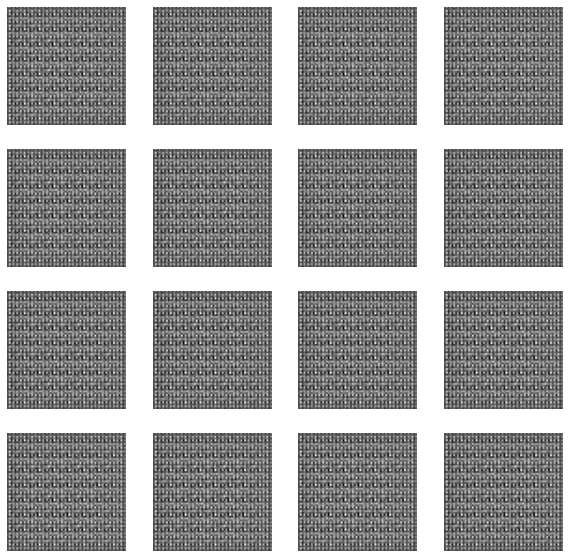


epoch 2/2
 96/259 [==========>...................] - ETA: 26:06 - gen_loss: 0.0055 - disc_loss: 6.3637

In [0]:
## Train
tf.keras.backend.clear_session()

model_name = time.strftime('%Y-%m-%d_%H:%M:%S')
if not os.path.exists(model_name):
  os.mkdir(model_name)
print("saving images in: {}".format(model_name))

generator=generator3d()
print(generator.summary())
discriminator=discriminator3d()
print(discriminator.summary())
generator_optimizer=tf.keras.optimizers.Adam(lr)
discriminator_optimizer=tf.keras.optimizers.Adam(lr)


train(dataset=parsed_dataset,
      num_training_samples = num_training_examples, 
      epochs=2, 
      batch_size=16, 
      lr=lr,
      save_dir_path = model_name)